**This is the notebook for the practical part of lab 1.** 

Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import gzip
import json
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from gensim.models import KeyedVectors
import gensim.downloader as api
from gensim.models import Word2Vec
import re
import copy

#import data_loading_code as dlc

In [2]:
print(torch.cuda.is_available())
#print(torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

True
Using device: cuda


## Load data

In [3]:
def preprocess_pandas(data): #, columns
    # df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    # for index, row in data.iterrows():
    #     word_tokens = word_tokenize(row['Sentence'])
    #     filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
    #     df_.loc[len(df_)] = {
    #         "index": row['index'],
    #         "Class": row['Class'],
    #         "Sentence": " ".join(filtered_sent)
    #     }
    #return df_
    return data


def split_data(data):
    # split the data into training, validation, and test splits
    # first get 50% for training
    X_train, X_rest, y_train, y_rest = train_test_split(
        data['Sentence'],
        data['Class'],
        test_size=0.5,
        random_state=0,
        shuffle=True
    )

    # split rest to get 50/20/30 split
    X_val, X_test, y_val, y_test = train_test_split(
        X_rest,
        y_rest,
        test_size=0.6,  # 60% of 50% = 30% test
        random_state=0,
        shuffle=True
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

small dataset

In [4]:
# load and pre-process data 
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)

data.columns = ['Sentence', 'Class']
data['index'] = data.index # add new column index
data = preprocess_pandas(data) # pre-process

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(data)

large dataset

In [5]:
# load and pre-process data
data_large = pd.read_csv("amazon_cells_labelled_LARGE_25K.txt", delimiter='\t', header=None)

data_large.columns = ['Sentence', 'Class']
data_large['index'] = data_large.index
data_large = preprocess_pandas(data_large)

# Split data
X_train_l, X_val_l, X_test_l, y_train_l, y_val_l, y_test_l = split_data(data_large)

Loading amazon review dataset 

Download the amazon reviews dataset 'Electronics_5.json.gz' on https://nijianmo.github.io/amazon/index.html#subsets. It is 1.2GB big.

Use following cell once to load, preprocess, and safe the dataset.

In [4]:
input_file = 'Electronics_5.json.gz'
output_file = 'electronics_reviews_preprocessed.parquet'

data_elec = []
with gzip.open(input_file, 'rt', encoding='utf-8') as f:
    for idx, line in enumerate(f):
        try:
            review = json.loads(line)
            overall = review.get('overall')
            text = review.get('reviewText')
            if overall is not None and text:  # ensure both exist
                data_elec.append({
                    'index': idx,
                    'Class': overall,
                    'Sentence': text.strip()
                })
        except json.JSONDecodeError:
            continue  # skip malformed lines

# Convert to DataFrame
data_elec = pd.DataFrame(data_elec)

# Preprocess data
data_elec = preprocess_pandas(data_elec)

# Converte DataFrame to PyArrow Table
table = pa.Table.from_pandas(data_elec)

# Save data in Parquet file to quickly access it again
pq.write_table(table, output_file)


In [4]:
# Load preprocessed dataset
table = pq.read_table('electronics_reviews_preprocessed.parquet')
data_elec = table.to_pandas()

# Split data
X_train_elec, X_val_elec, X_test_elec, y_train_elec, y_val_elec, y_test_elec = split_data(data_elec)

## Vectorise using tfidf

In [12]:
def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, tfidf_vectorizer, batch_size=32, handle_class_imbalance=False):
    """
    Convert text data to TF-IDF vectors, then to PyTorch tensors, and return DataLoaders for train, validation, and test sets.
    
    Parameters:
    - X_train: List or array of training sentences.
    - X_val: List or array of validation sentences.
    - X_test: List or array of test sentences.
    - y_train: List or array of training labels.
    - y_val: List or array of validation labels.
    - y_test: List or array of test labels.
    - tfidf_vectorizer: A fitted TfidfVectorizer.
    - batch_size: Batch size for DataLoader (default is 32).
    
    Returns:
    - train_loader: DataLoader for the training set.
    - val_loader: DataLoader for the validation set.
    - test_loader: DataLoader for the test set.
    """

    # if handle_class_imbalance:
        # classes_len = []
        # for i in range(handle_class_imbalance):
        #     classes_len.append(len(list(filter(lambda x: x == i+1, y_train))))
        # total = sum(classes_len)
        # part = list(map(lambda val: val/total, classes_len))
        # print(classes_len)
        # print(total)
        # print(part)

    
    # Transform texts to sparse matrix and then to dense matrix for Pytorch
    X_train_vec = tfidf_vectorizer.fit_transform(X_train).todense()
    X_val_vec = tfidf_vectorizer.transform(X_val).todense()
    X_test_vec = tfidf_vectorizer.transform(X_test).todense()

    # NOTE: This isn't fully done yet
    # if handle_class_imbalance:
        # pass

    # Convert to tensors
    train_x_tensor = torch.from_numpy(np.array(X_train_vec)).type(torch.FloatTensor).to(device)
    train_y_tensor = torch.from_numpy(np.array(y_train)).type(torch.FloatTensor).to(device)

    val_x_tensor = torch.from_numpy(np.array(X_val_vec)).type(torch.FloatTensor).to(device)
    val_y_tensor = torch.from_numpy(np.array(y_val)).type(torch.FloatTensor).to(device)

    test_x_tensor = torch.from_numpy(np.array(X_test_vec)).type(torch.FloatTensor).to(device)
    test_y_tensor = torch.from_numpy(np.array(y_test)).type(torch.FloatTensor).to(device)

    # Build datasets
    train_dataset = TensorDataset(train_x_tensor, train_y_tensor)
    val_dataset = TensorDataset(val_x_tensor, val_y_tensor)
    test_dataset = TensorDataset(test_x_tensor, test_y_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [13]:
# vectorize data using TFIDF and transform for PyTorch for scalability
tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
# The amazon dataset needs less max_features
# rough math is 3_000_000 rows * float64 * max_features -> 3MB * 8B * max_features -> 24MB * max_features
#   I initially took 100 features, therefore we need 2.4GB RAM
#   Going with 300 features requires around 7.2GB GPU RAM 
tfidf_vectorizer_elec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=100, max_df=0.5, use_idf=True, norm='l2')

**Create DataLoaders**

small dataset

In [14]:
train_loader, val_loader, test_loader = create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, tfidf_vectorizer, batch_size=16)

large dataset

In [35]:
train_loader_l, val_loader_l, test_loader_l = create_data_loaders(X_train_l, X_val_l, X_test_l, y_train_l, y_val_l, y_test_l, tfidf_vectorizer)

amazon electronics review dataset

In [ ]:
train_loader_elec, val_loader_elec, test_loader_elec = create_data_loaders(X_train_elec, X_val_elec, X_test_elec, y_train_elec, y_val_elec, y_test_elec, tfidf_vectorizer_elec, handle_class_imbalance=5)

## Sentence embeddings using Word2Vec for vectorization

In [13]:
# # load pretrained word2vec model with dimension 100
# word2vec_model = api.load("glove-wiki-gigaword-100")
# embedding_dim = 100 

In [36]:
sentences = list(X_train) + list(X_val) + list(X_test)
# Tokenize sentences
tokenized_sentences = [word_tokenize(sentence.lower()) for sentence in sentences]

sentences_l = list(X_train_l) + list(X_val_l) + list(X_test_l)
# Tokenize sentences
tokenized_sentences_l = [word_tokenize(sentence.lower()) for sentence in sentences_l]

In [37]:
# Train Word2Vec 
word2vec_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,       # dimension of vectors
    window=5,              
    min_count=1,           # min. appearance of a word in dataset
    workers=4,             
    sg=0                   # 1 = skip-gram, 0 = CBOW
)

word2vec_model_l = Word2Vec(
    sentences=tokenized_sentences_l,
    vector_size=100,       # dimension of vectors
    window=5,              
    min_count=1,           # min. appearance of a word in dataset
    workers=4,             
    sg=0                   # 1 = skip-gram, 0 = CBOW
)

In [44]:
# Function to convert sentences into embeddings
def sentence_to_vec(sentence, model, embedding_dim=100):
    words = sentence.split()
    vec = torch.zeros(embedding_dim).to(device)
    word_count = 0
    for word in words:
        if word in model.wv:
            vec += torch.tensor(model.wv[word]).to(device)
            word_count += 1
    if word_count > 0:
        vec /= word_count
    return vec

# Convert all sentences to embeddings for the datasets
def create_dataset(X, y, word2vec_model, embedding_dim=100):
    x_tensor = torch.stack([sentence_to_vec(sentence, word2vec_model, embedding_dim) for sentence in X]).to(device)
    y_tensor = torch.tensor(np.array(y), dtype=torch.float32).to(device)  # Binary labels as float32
    return x_tensor, y_tensor

small dataset

In [45]:
# Create Tensor datasets
train_x_tensor_w2v, train_y_tensor_w2v = create_dataset(X_train, y_train, word2vec_model)
val_x_tensor_w2v, val_y_tensor_w2v = create_dataset(X_val, y_val, word2vec_model)
test_x_tensor_w2v, test_y_tensor_w2v = create_dataset(X_test, y_test, word2vec_model)

# Build datasets and DataLoaders
train_loader_w2v = DataLoader(TensorDataset(train_x_tensor_w2v, train_y_tensor_w2v), batch_size=32, shuffle=True)
val_loader_w2v = DataLoader(TensorDataset(val_x_tensor_w2v, val_y_tensor_w2v), batch_size=32, shuffle=False)
test_loader_w2v = DataLoader(TensorDataset(test_x_tensor_w2v, test_y_tensor_w2v), batch_size=32, shuffle=False)

large dataset

In [46]:
# Create Tensor datasets
train_x_tensor_w2v_l, train_y_tensor_w2v_l = create_dataset(X_train_l, y_train_l, word2vec_model_l)
val_x_tensor_w2v_l, val_y_tensor_w2v_l = create_dataset(X_val_l, y_val_l, word2vec_model_l)
test_x_tensor_w2v_l, test_y_tensor_w2v_l = create_dataset(X_test_l, y_test_l, word2vec_model_l)

# Build datasets and DataLoaders
train_loader_w2v_l = DataLoader(TensorDataset(train_x_tensor_w2v_l, train_y_tensor_w2v_l), batch_size=32, shuffle=True)
val_loader_w2v_l = DataLoader(TensorDataset(val_x_tensor_w2v_l, val_y_tensor_w2v_l), batch_size=32, shuffle=False)
test_loader_w2v_l = DataLoader(TensorDataset(test_x_tensor_w2v_l, test_y_tensor_w2v_l), batch_size=32, shuffle=False)

---

# ANN Classifier

In [8]:
class ANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(16, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc3 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification
        return x

In [9]:
class SimpleANNClassifier(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(SimpleANNClassifier, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid for binary classification
        return x

In [10]:
class SimpleANNClassifierMulti(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(SimpleANNClassifierMulti, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 8)
        self.bn1 = nn.BatchNorm1d(8)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.7)

        self.fc2 = nn.Linear(8, 6)  # Ratings 0-5 

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.drop1(self.relu1(self.bn1(self.fc1(x))))
        x = torch.softmax(self.fc2(x), 0)
        print(x)
        return x

In [11]:
class ANNClassifierLarge(nn.Module):
    def __init__(self, input_size, name = 'default'):
        super(ANNClassifierLarge, self).__init__()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)

        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.drop1 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(64, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.relu3 = nn.LeakyReLU(negative_slope=0.01)
        self.drop2 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(16, 1)  # Single neuron output

        self.name = name + '.pth'

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.bn1(self.fc1(x)))
        x = self.drop1(self.relu2(self.bn2(self.fc2(x))))
        x = self.drop2(self.relu3(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))  # Sigmoid for binary classification
        return x

In [12]:
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs, mod=False):
    train_loss_array = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)  # [batch, 1] for BCELoss
            if(mod):
                labels = mod(labels)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_train_loss += loss.item()

        train_acc = 100 * correct / total
        training_loss = running_train_loss / len(train_loader)
        train_loss_array.append(training_loss)

        val_loss, val_acc, _, _ = test_model(loader=val_loader, model=model, criterion=criterion, mod=mod)

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, model.name)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {training_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    print(f"Best validation accuracy: {best_accuracy}%")
    return model


def test_model(loader, model=None, criterion=None, input_size=None, mod=False):
    if model is None:
        model = ANNClassifier(input_size)
        model.load_state_dict(torch.load('amazonclass.pth'))

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.float().unsqueeze(1)
            if(mod):
                labels = mod(labels)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            predicted = (outputs >= 0.5).int()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

            all_labels.extend(labels.squeeze().tolist())
            all_preds.extend(predicted.squeeze().tolist())

    loss = running_loss / len(loader)
    accuracy = 100 * correct / total

    return loss, accuracy, np.array(all_labels), np.array(all_preds)

In [13]:
def plot_confusion_matrix(all_labels=None, all_predictions=None, class_labels=None):
    if all_labels is None or all_predictions is None:
        print("Error: all_labels or all_predictions needs to be passed")
        return

    if class_labels is None:
        class_labels = ["Negative (0)", "Positive (1)"]  # Default

    # Compute the confusion matrix
    cm = metrics.confusion_matrix(all_labels, all_predictions)
    # print("Confusion Matrix:\n", cm)

    # Plot it with descriptive labels
    fig, ax = plt.subplots(figsize=(6, 6))
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    cm_display.plot(cmap='Blues', values_format='d', ax=ax)

    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

---

# Training and Evaluation of ANNs

## Train simple ANN Classifier on small dataset

In [52]:
model_name ='amazonclasssimple'
input_size = next(iter(train_loader))[0].shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=250)

Epoch 1/250, Train Loss: 0.7711, Val Loss: 0.6937, Train Acc: 49.20%, Val Acc: 47.00%
Epoch 2/250, Train Loss: 0.7470, Val Loss: 0.6950, Train Acc: 51.20%, Val Acc: 49.00%
Epoch 3/250, Train Loss: 0.6977, Val Loss: 0.6989, Train Acc: 53.00%, Val Acc: 51.50%
Epoch 4/250, Train Loss: 0.6840, Val Loss: 0.6943, Train Acc: 58.40%, Val Acc: 52.50%
Epoch 5/250, Train Loss: 0.6520, Val Loss: 0.6863, Train Acc: 62.20%, Val Acc: 57.00%
Epoch 6/250, Train Loss: 0.6225, Val Loss: 0.6774, Train Acc: 66.20%, Val Acc: 56.50%
Epoch 7/250, Train Loss: 0.6213, Val Loss: 0.6680, Train Acc: 64.00%, Val Acc: 59.50%
Epoch 8/250, Train Loss: 0.6114, Val Loss: 0.6633, Train Acc: 66.40%, Val Acc: 61.00%
Epoch 9/250, Train Loss: 0.5696, Val Loss: 0.6558, Train Acc: 70.20%, Val Acc: 62.00%
Epoch 10/250, Train Loss: 0.5481, Val Loss: 0.6511, Train Acc: 74.40%, Val Acc: 63.50%
Epoch 11/250, Train Loss: 0.5379, Val Loss: 0.6450, Train Acc: 73.00%, Val Acc: 63.50%
Epoch 12/250, Train Loss: 0.5249, Val Loss: 0.6436, 

Accuracy on testing dataset: 81.33333333333333%
F1-Score: 0.82


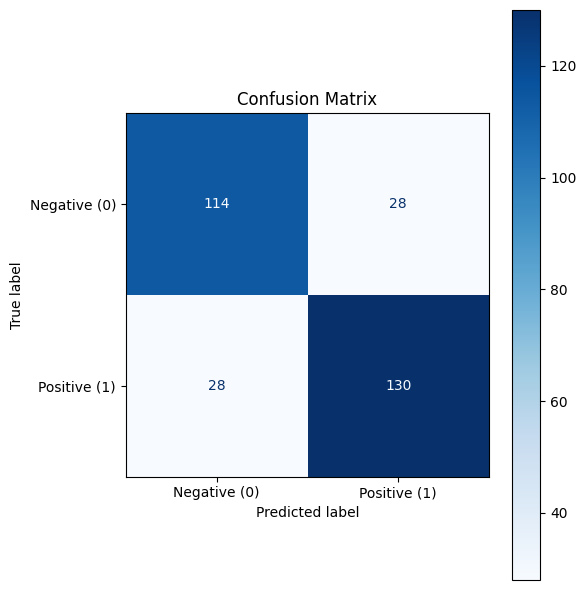

In [53]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train simple ANN Classifier on large dataset

In [54]:
model_name ='amazonclasssimplelarge'
input_size = next(iter(train_loader_l))[0].shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_l, val_loader_l, num_epochs=25)

Epoch 1/25, Train Loss: 0.6273, Val Loss: 0.5445, Train Acc: 67.80%, Val Acc: 84.24%
Epoch 2/25, Train Loss: 0.5471, Val Loss: 0.4964, Train Acc: 77.66%, Val Acc: 87.00%
Epoch 3/25, Train Loss: 0.4963, Val Loss: 0.4544, Train Acc: 80.17%, Val Acc: 87.38%
Epoch 4/25, Train Loss: 0.4557, Val Loss: 0.4208, Train Acc: 82.15%, Val Acc: 88.08%
Epoch 5/25, Train Loss: 0.4209, Val Loss: 0.3871, Train Acc: 83.45%, Val Acc: 87.34%
Epoch 6/25, Train Loss: 0.3936, Val Loss: 0.3646, Train Acc: 84.04%, Val Acc: 88.14%
Epoch 7/25, Train Loss: 0.3680, Val Loss: 0.3455, Train Acc: 84.54%, Val Acc: 88.36%
Epoch 8/25, Train Loss: 0.3541, Val Loss: 0.3326, Train Acc: 84.45%, Val Acc: 88.42%
Epoch 9/25, Train Loss: 0.3371, Val Loss: 0.3237, Train Acc: 84.96%, Val Acc: 88.56%
Epoch 10/25, Train Loss: 0.3225, Val Loss: 0.3084, Train Acc: 85.53%, Val Acc: 88.28%
Epoch 11/25, Train Loss: 0.3089, Val Loss: 0.2996, Train Acc: 85.65%, Val Acc: 88.38%
Epoch 12/25, Train Loss: 0.2946, Val Loss: 0.2949, Train Acc: 8

Accuracy on testing dataset: 88.24%
F1-Score: 0.90


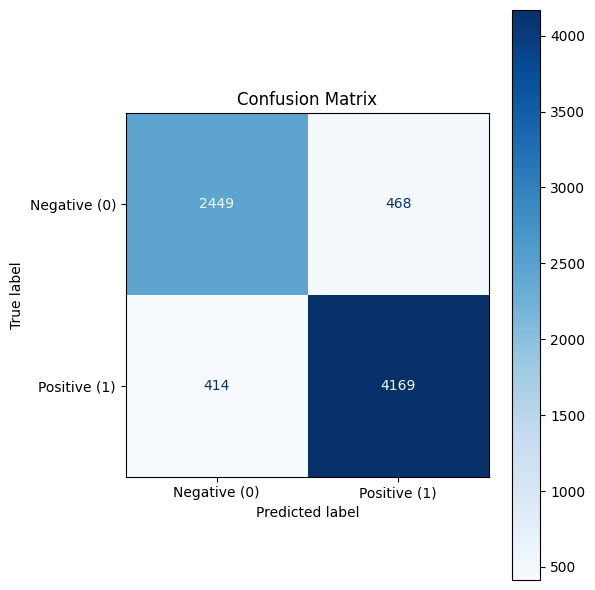

In [55]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train ANN Classifier on large dataset

In [56]:
model_name_l = 'amazonclasslarge'
input_size = next(iter(train_loader_l))[0].shape[1]
model = ANNClassifier(input_size, model_name_l)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

trained_model = train_model(model, criterion, optimizer, train_loader_l, val_loader_l, num_epochs=25)

Epoch 1/25, Train Loss: 0.6000, Val Loss: 0.4585, Train Acc: 67.78%, Val Acc: 83.08%
Epoch 2/25, Train Loss: 0.4509, Val Loss: 0.3651, Train Acc: 80.27%, Val Acc: 86.40%
Epoch 3/25, Train Loss: 0.3333, Val Loss: 0.3285, Train Acc: 85.19%, Val Acc: 86.72%
Epoch 4/25, Train Loss: 0.2571, Val Loss: 0.3200, Train Acc: 88.21%, Val Acc: 86.78%
Epoch 5/25, Train Loss: 0.2186, Val Loss: 0.3339, Train Acc: 88.94%, Val Acc: 86.68%
Epoch 6/25, Train Loss: 0.1961, Val Loss: 0.3592, Train Acc: 89.44%, Val Acc: 86.32%
Epoch 7/25, Train Loss: 0.1960, Val Loss: 0.3935, Train Acc: 89.22%, Val Acc: 85.60%
Epoch 8/25, Train Loss: 0.1901, Val Loss: 0.4099, Train Acc: 89.51%, Val Acc: 86.42%
Epoch 9/25, Train Loss: 0.1889, Val Loss: 0.4536, Train Acc: 89.48%, Val Acc: 85.86%
Epoch 10/25, Train Loss: 0.1941, Val Loss: 0.4556, Train Acc: 88.99%, Val Acc: 85.80%
Epoch 11/25, Train Loss: 0.1857, Val Loss: 0.4490, Train Acc: 89.88%, Val Acc: 86.04%
Epoch 12/25, Train Loss: 0.1850, Val Loss: 0.4486, Train Acc: 8

Accuracy on testing dataset: 87.28%
F1-Score: 0.90


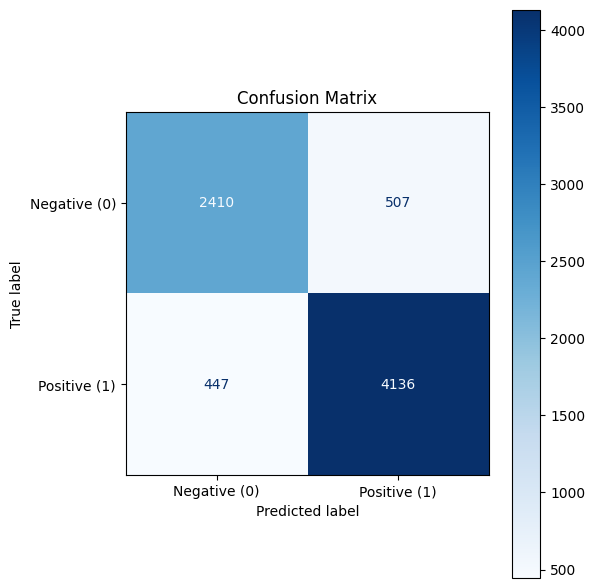

In [57]:
# Load best model
model = ANNClassifier(input_size, model_name_l)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

## Train ANN Classifier on Amazon Electronics Dataset

In [14]:
model_name_elec = 'amazonElectronics'
input_size = next(iter(train_loader_elec))[0].shape[1]
model = ANNClassifierLarge(input_size, model_name_elec)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# This isn't really great for performance, but we need to be a bit
# more flexible with out data. Also, all of those operations are
# performed on the GPU, so this should be fine ig
def bin_mapper(labels):
    return (labels >= 4).float()

trained_model = train_model(model, criterion, optimizer, train_loader_elec, val_loader_elec, num_epochs=5, mod=bin_mapper)

Epoch 1/5, Train Loss: 0.3726, Val Loss: 0.3550, Train Acc: 83.49%, Val Acc: 84.30%
Epoch 2/5, Train Loss: 0.3647, Val Loss: 0.3522, Train Acc: 83.91%, Val Acc: 84.51%
Epoch 3/5, Train Loss: 0.3626, Val Loss: 0.3506, Train Acc: 84.01%, Val Acc: 84.53%
Epoch 4/5, Train Loss: 0.3612, Val Loss: 0.3512, Train Acc: 84.09%, Val Acc: 84.47%
Epoch 5/5, Train Loss: 0.3606, Val Loss: 0.3500, Train Acc: 84.12%, Val Acc: 84.57%
Best validation accuracy: 84.57459557287628%


Accuracy on testing dataset: 84.53893994079561%
F1-Score: 0.91
Precision-Score: 0.86
Recall-Score: 0.97


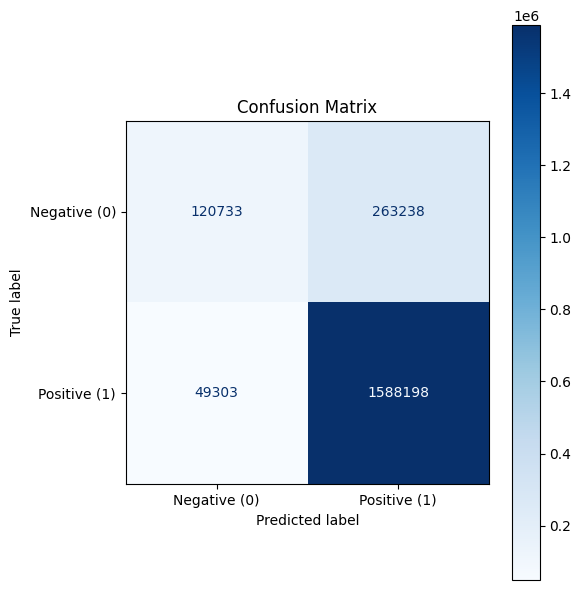

In [16]:
# Load best model
model_name_elec = 'amazonElectronics'
input_size = next(iter(train_loader_elec))[0].shape[1]
model = ANNClassifierLarge(input_size, model_name_elec)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

def bin_mapper(labels):
    return (labels >= 4).float()

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_elec, criterion=criterion, input_size=input_size, mod=bin_mapper)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
print(f'Precision-Score: {precision_score(labels, preds):.2f}')
print(f'Recall-Score: {recall_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

Reasoning: The amazon model is heavily biased towards TP. This is due to the provided dataset has a lot 4 and 5 star ratings:

`{5.0: 4_322_520, 3.0: 504_712, 4.0: 1_137_229, 2.0: 306_659, 1.0: 467_117}`

That might be the reason why the model has a lot of FP.

---

## Train ANN with word embeddings
small dataset and small model

In [58]:
model_name ='amazonclasssimplew2v'
input_size = train_x_tensor_w2v.shape[1]
model = SimpleANNClassifier(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v, val_loader_w2v, num_epochs=500)

Epoch 1/500, Train Loss: 0.7357, Val Loss: 0.7018, Train Acc: 48.00%, Val Acc: 47.00%
Epoch 2/500, Train Loss: 0.7059, Val Loss: 0.7020, Train Acc: 53.40%, Val Acc: 47.00%
Epoch 3/500, Train Loss: 0.7062, Val Loss: 0.7004, Train Acc: 52.20%, Val Acc: 47.50%
Epoch 4/500, Train Loss: 0.7233, Val Loss: 0.7387, Train Acc: 51.40%, Val Acc: 48.50%
Epoch 5/500, Train Loss: 0.7400, Val Loss: 0.6955, Train Acc: 49.00%, Val Acc: 46.00%
Epoch 6/500, Train Loss: 0.7214, Val Loss: 0.6971, Train Acc: 45.40%, Val Acc: 45.50%
Epoch 7/500, Train Loss: 0.7446, Val Loss: 0.6902, Train Acc: 46.80%, Val Acc: 52.00%
Epoch 8/500, Train Loss: 0.7037, Val Loss: 0.6904, Train Acc: 52.00%, Val Acc: 52.00%
Epoch 9/500, Train Loss: 0.7151, Val Loss: 0.7037, Train Acc: 49.40%, Val Acc: 50.00%
Epoch 10/500, Train Loss: 0.7124, Val Loss: 0.7067, Train Acc: 50.60%, Val Acc: 51.00%
Epoch 11/500, Train Loss: 0.7179, Val Loss: 0.7032, Train Acc: 50.80%, Val Acc: 47.00%
Epoch 12/500, Train Loss: 0.7263, Val Loss: 0.6956, 

Accuracy on testing dataset: 66.33333333333333%
F1-Score: 0.64


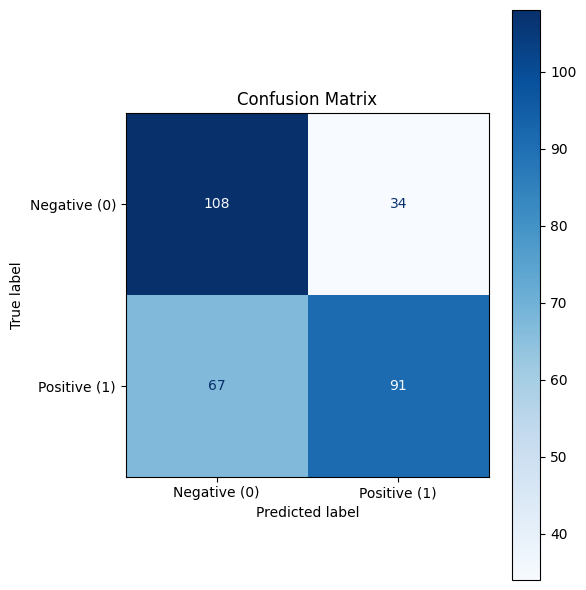

In [59]:
# Load best model
model = SimpleANNClassifier(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

larger dataset and larger model

In [60]:
model_name ='amazonclasssimplew2vlarge'
input_size = train_x_tensor_w2v_l.shape[1]
model = ANNClassifierLarge(input_size, model_name)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

trained_model = train_model(model, criterion, optimizer, train_loader_w2v_l, val_loader_w2v_l, num_epochs=50)

Epoch 1/50, Train Loss: 0.5057, Val Loss: 0.4617, Train Acc: 74.79%, Val Acc: 76.26%
Epoch 2/50, Train Loss: 0.4550, Val Loss: 0.4558, Train Acc: 78.30%, Val Acc: 78.18%
Epoch 3/50, Train Loss: 0.4443, Val Loss: 0.4422, Train Acc: 79.14%, Val Acc: 78.26%
Epoch 4/50, Train Loss: 0.4369, Val Loss: 0.4343, Train Acc: 79.62%, Val Acc: 78.14%
Epoch 5/50, Train Loss: 0.4279, Val Loss: 0.4314, Train Acc: 79.76%, Val Acc: 79.16%
Epoch 6/50, Train Loss: 0.4267, Val Loss: 0.4455, Train Acc: 79.81%, Val Acc: 77.80%
Epoch 7/50, Train Loss: 0.4254, Val Loss: 0.4785, Train Acc: 80.06%, Val Acc: 77.04%
Epoch 8/50, Train Loss: 0.4195, Val Loss: 0.4444, Train Acc: 80.18%, Val Acc: 78.68%
Epoch 9/50, Train Loss: 0.4178, Val Loss: 0.4305, Train Acc: 80.36%, Val Acc: 79.34%
Epoch 10/50, Train Loss: 0.4105, Val Loss: 0.4372, Train Acc: 80.94%, Val Acc: 78.50%
Epoch 11/50, Train Loss: 0.4063, Val Loss: 0.4377, Train Acc: 80.98%, Val Acc: 78.98%
Epoch 12/50, Train Loss: 0.4055, Val Loss: 0.4488, Train Acc: 8

Accuracy on testing dataset: 79.17333333333333%
F1-Score: 0.83


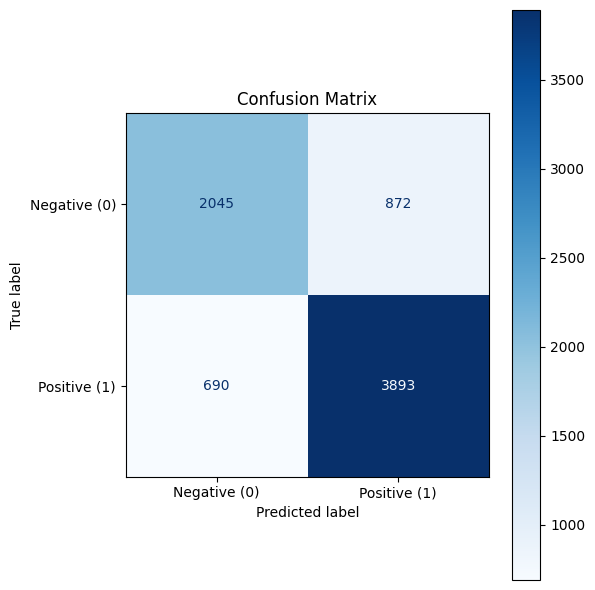

In [61]:
# Load best model
model = ANNClassifierLarge(input_size, model_name)
model.load_state_dict(torch.load(model.name, weights_only=True))
model.to(device)

# Evaluate best model
_, test_acc, labels, preds = test_model(model=model, loader=test_loader_w2v_l, criterion=criterion, input_size=input_size)
print(f'Accuracy on testing dataset: {test_acc}%')
print(f'F1-Score: {f1_score(labels, preds):.2f}')
plot_confusion_matrix(labels, preds)

---

# Transformer

### RoBERTa

In this part we perform feature extraction on the RoBERTa transformer model for binary classification

In [6]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score

2025-05-21 21:37:52.788208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 21:37:52.802760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747856272.822054  138574 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747856272.827855  138574 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747856272.842171  138574 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

#### Small Dataset

In [7]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def create_dataset(X_train, y_train, X_val, y_val, X_test, y_test):
    train_dataset = Dataset.from_dict({"sentence": X_train, "labels": y_train})
    val_dataset = Dataset.from_dict({"sentence": X_val, "labels": y_val})
    test_dataset = Dataset.from_dict({"sentence": X_test, "labels": y_test})
    return train_dataset.map(tokenize, batched=True), val_dataset.map(tokenize, batched=True), test_dataset.map(tokenize, batched=True)

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "precision": precision_score(labels, preds),
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "recall": recall_score(labels, preds)
    }

# Create small and large dataset
train_dataset, val_dataset, test_dataset = create_dataset(X_train, y_train, X_val, y_val, X_test, y_test)
train_dataset_l, val_dataset_l, test_dataset_l = create_dataset(X_train_l, y_train_l, X_val_l, y_val_l, X_test_l, y_test_l)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

In [28]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        logging_dir="./logs",
        num_train_epochs=3,
        per_device_train_batch_size=8
    ),
    train_dataset = train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,No log,0.298316,0.954023,0.925000,0.917127,0.882979
2,No log,0.571897,0.849057,0.900000,0.900000,0.957447
3,No log,0.254291,0.946809,0.950000,0.946809,0.946809


TrainOutput(global_step=189, training_loss=0.2952616252596416, metrics={'train_runtime': 112.7971, 'train_samples_per_second': 13.298, 'train_steps_per_second': 1.676, 'total_flos': 30062493630000.0, 'train_loss': 0.2952616252596416, 'epoch': 3.0})

In [29]:
metrics = trainer.evaluate(
    eval_dataset=test_dataset,
)

print(metrics)

{'eval_loss': 0.20251715183258057, 'eval_precision': 0.9625, 'eval_accuracy': 0.9666666666666667, 'eval_f1': 0.9685534591194969, 'eval_recall': 0.9746835443037974, 'eval_runtime': 3.3241, 'eval_samples_per_second': 90.25, 'eval_steps_per_second': 11.432, 'epoch': 3.0}


#### Playground
Cause it is fancy to try around

In [30]:
# It is really fancy to try it a bit out
text = "does what it promised"
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
print(f"Predicted class: {predicted_class}")
print(f"Probabilities: {probabilities.numpy()}")

Predicted class: 1
Probabilities: [[0.0043547 0.9956453]]


#### Large Dataset

In [9]:
model_l = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)
trainer_l = Trainer(
    model=model_l,
    args=TrainingArguments(
        output_dir="./results_large",
        eval_strategy="epoch",
        logging_dir="./logs_large",
        num_train_epochs=3,
        per_device_train_batch_size=8
    ),
    train_dataset = train_dataset_l,
    eval_dataset = val_dataset_l,
    compute_metrics=compute_metrics
)

trainer_l.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.329300,0.276609,0.935792,0.917800,0.932568,0.929366
2,0.219700,0.253355,0.947941,0.932200,0.944362,0.940811
3,0.148100,0.298459,0.942221,0.936400,0.948343,0.954545


TrainOutput(global_step=4689, training_loss=0.24563814017990807, metrics={'train_runtime': 1082.5085, 'train_samples_per_second': 34.642, 'train_steps_per_second': 4.332, 'total_flos': 9866664576000000.0, 'train_loss': 0.24563814017990807, 'epoch': 3.0})

In [10]:
metrics = trainer_l.evaluate(
    eval_dataset=test_dataset_l,
)

print(metrics)

{'eval_loss': 0.2807043194770813, 'eval_precision': 0.9447918913090361, 'eval_accuracy': 0.9389333333333333, 'eval_f1': 0.9503253796095444, 'eval_recall': 0.9559240672048877, 'eval_runtime': 54.6927, 'eval_samples_per_second': 137.13, 'eval_steps_per_second': 17.15, 'epoch': 3.0}


### WandB optimisation of RoBERTa

In [5]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score

import wandb

import torch
import gc

2025-05-21 23:58:58.233282: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 23:58:58.248536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747864738.269315  147385 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747864738.275321  147385 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747864738.290939  147385 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

def create_dataset(X_train, y_train, X_val, y_val, X_test, y_test):
    train_dataset = Dataset.from_dict({"sentence": X_train, "labels": y_train})
    val_dataset = Dataset.from_dict({"sentence": X_val, "labels": y_val})
    test_dataset = Dataset.from_dict({"sentence": X_test, "labels": y_test})
    return train_dataset.map(tokenize, batched=True), val_dataset.map(tokenize, batched=True), test_dataset.map(tokenize, batched=True)

def tokenize(batch):
    return tokenizer(batch["sentence"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "precision": precision_score(labels, preds),
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "recall": recall_score(labels, preds)
    }

# Create small and large dataset
train_dataset, val_dataset, test_dataset = create_dataset(X_train, y_train, X_val, y_val, X_test, y_test)
#train_dataset_l, val_dataset_l, test_dataset_l = create_dataset(X_train_l, y_train_l, X_val_l, y_val_l, X_test_l, y_test_l)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Small dataset

In [ ]:
wandb.login()

In [14]:
sweep_config = {
    "method": "bayes",
    "metric": {
        "name": "eval/f1",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {
            "min": 1e-6,
            "max": 5e-5
        },
        "per_device_train_batch_size": {
            "values": [8, 16, 32]
        },
        "num_train_epochs": {
            "values": [2, 3, 4]
        }
    }
}

In [15]:
sweep_id = wandb.sweep(sweep_config, project="roberta-sweep-lab1")

Create sweep with ID: wecneufa
Sweep URL: https://wandb.ai/natalia-timokhova-v-lule-university-of-technology/roberta-sweep-lab1/sweeps/wecneufa


In [16]:
def train():
    with wandb.init() as run:
        config = run.config

        model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

        training_args = TrainingArguments(
            output_dir="./results",
            eval_strategy="epoch",
            logging_dir="./logs",
            report_to="wandb",
            learning_rate=config.learning_rate,
            per_device_train_batch_size=config.per_device_train_batch_size,
            num_train_epochs=config.num_train_epochs,
            logging_steps=10,
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="f1",
            greater_is_better=True
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics
        )

        trainer.train()

        # Save model 
        model_dir = f"./models/{wandb.run.name}"
        trainer.save_model(model_dir)
        wandb.save(f"{model_dir}/*") 

        del trainer
        del model
        gc.collect()
        torch.cuda.empty_cache()

In [17]:
wandb.agent(sweep_id, function=train, count=20)

wandb: Agent Starting Run: isndre95 with config:
wandb: 	learning_rate: 1.185334974456161e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.611400,0.418820,0.946809,0.950000,0.946809,0.946809
2,0.240700,0.257434,0.919192,0.945000,0.943005,0.968085
3,0.188200,0.256254,0.937500,0.950000,0.947368,0.957447


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,█▁█
eval/f1,▇▁█
eval/loss,█▁▁
eval/precision,█▁▆
eval/recall,▁█▅
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇███
train/grad_norm,▁▁▁▁▁▁▂▂▃▁▇█▁▁▁▁▁▁


wandb: Agent Starting Run: us7ipbia with config:
wandb: 	learning_rate: 4.917464376348869e-05
wandb: 	num_train_epochs: 4
wandb: 	per_device_train_batch_size: 8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.323200,0.317384,0.926316,0.935000,0.931217,0.936170
2,0.292700,0.358674,0.871287,0.905000,0.902564,0.936170
3,0.128200,0.291469,0.977011,0.945000,0.939227,0.904255
4,0.138500,0.295266,0.936842,0.945000,0.941799,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▆▁██
eval/f1,▆▁██
eval/loss,▄█▁▁
eval/precision,▅▁█▅
eval/recall,▆▆▁█
eval/runtime,▁▆▇█
eval/samples_per_second,█▃▂▁
eval/steps_per_second,█▃▂▁
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇████
train/grad_norm,▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁


wandb: Agent Starting Run: 83wbkcwc with config:
wandb: 	learning_rate: 3.096975465549019e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.406900,0.227441,0.928571,0.950000,0.947917,0.968085
2,0.003200,0.253711,0.957447,0.960000,0.957447,0.957447
3,0.184600,0.253309,0.957447,0.960000,0.957447,0.957447


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▁██
eval/f1,▁██
eval/loss,▁██
eval/precision,▁██
eval/recall,█▁▁
eval/runtime,▁▇█
eval/samples_per_second,█▂▁
eval/steps_per_second,█▂▁
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▆▇▇███
train/grad_norm,▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁


wandb: Agent Starting Run: cvs0003s with config:
wandb: 	learning_rate: 3.828490382974806e-05
wandb: 	num_train_epochs: 4
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.280200,0.221451,0.945652,0.940000,0.935484,0.925532
2,0.169800,0.265164,0.872549,0.910000,0.908163,0.946809
3,0.057000,0.433979,0.875000,0.920000,0.919192,0.968085
4,0.109000,0.362083,0.883495,0.925000,0.923858,0.968085


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,█▁▃▅
eval/f1,█▁▄▅
eval/loss,▁▂█▆
eval/precision,█▁▁▂
eval/recall,▁▅██
eval/runtime,▁▅██
eval/samples_per_second,█▄▁▁
eval/steps_per_second,█▄▁▁
train/epoch,▁▂▂▂▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▂▂▂▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,▁▂▁▁▄█▆▆▂▁▁▁


wandb: Agent Starting Run: 354ggpcy with config:
wandb: 	learning_rate: 2.7507103932419822e-05
wandb: 	num_train_epochs: 4
wandb: 	per_device_train_batch_size: 8


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.503800,0.206535,0.956522,0.950000,0.946237,0.936170
2,0.143100,0.319048,0.918367,0.940000,0.937500,0.957447
3,0.145600,0.232690,0.947368,0.955000,0.952381,0.957447
4,0.001100,0.343996,0.918367,0.940000,0.937500,0.957447


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▆▁█▁
eval/f1,▅▁█▁
eval/loss,▁▇▂█
eval/precision,█▁▆▁
eval/recall,▁███
eval/runtime,▁▄██
eval/samples_per_second,█▅▁▁
eval/steps_per_second,█▅▁▁
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇████
train/grad_norm,▁▁▂▁▁▂█▁▂▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁


wandb: Agent Starting Run: agwef8p6 with config:
wandb: 	learning_rate: 2.573010616660904e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.540700,0.203563,0.946237,0.945000,0.941176,0.936170
2,0.151600,0.172564,0.947368,0.955000,0.952381,0.957447
3,0.018900,0.209999,0.956989,0.955000,0.951872,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▁██
eval/f1,▁██
eval/loss,▇▁█
eval/precision,▁▂█
eval/recall,▁█▅
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▂▃▃▃▄▅▅▆▇███
train/global_step,▁▂▃▃▃▄▅▅▆▇███
train/grad_norm,▁▁▁▁▅█▁▂▁


wandb: Agent Starting Run: p6sebaro with config:
wandb: 	learning_rate: 2.8874019251693835e-05
wandb: 	num_train_epochs: 4
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.376000,0.212822,0.917526,0.935000,0.931937,0.946809
2,0.171300,0.270593,0.927835,0.945000,0.942408,0.957447
3,0.092900,0.226091,0.946809,0.950000,0.946809,0.946809
4,0.060500,0.305337,0.918367,0.940000,0.937500,0.957447


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▁▆█▃
eval/f1,▁▆█▄
eval/loss,▁▅▂█
eval/precision,▁▃█▁
eval/recall,▁█▁█
eval/runtime,▁▅█▇
eval/samples_per_second,█▄▁▂
eval/steps_per_second,█▄▁▂
train/epoch,▁▂▂▂▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▂▂▂▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,▁▁▁▁█▂▁▁▄▁▁▁


wandb: Agent Starting Run: cu2y0wpj with config:
wandb: 	learning_rate: 2.9973920503521943e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.447500,0.155788,0.967033,0.955000,0.951351,0.936170
2,0.101600,0.241730,0.909091,0.935000,0.932642,0.957447
3,0.007700,0.185561,0.967391,0.960000,0.956989,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▇▁█
eval/f1,▆▁█
eval/loss,▁█▃
eval/precision,█▁█
eval/recall,▁█▅
eval/runtime,▁▃█
eval/samples_per_second,█▆▁
eval/steps_per_second,█▅▁
train/epoch,▁▂▃▃▃▄▅▅▆▇███
train/global_step,▁▂▃▃▃▄▅▅▆▇███
train/grad_norm,▁▁▁▁█▁▁▄▁


wandb: Agent Starting Run: 64smzt72 with config:
wandb: 	learning_rate: 3.393093929925325e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.350400,0.207008,0.916667,0.930000,0.926316,0.936170
2,0.188300,0.162124,0.967391,0.960000,0.956989,0.946809
3,0.053700,0.184019,0.988764,0.965000,0.961749,0.936170


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▁▇█
eval/f1,▁▇█
eval/loss,█▁▄
eval/precision,▁▆█
eval/recall,▁█▁
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▂▃▃▃▄▅▅▆▇███
train/global_step,▁▂▃▃▃▄▅▅▆▇███
train/grad_norm,▁▂▁▁▇█▁▃▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7pv9zaoi with config:
wandb: 	learning_rate: 3.624221878420868e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.371500,0.192829,0.946237,0.945000,0.941176,0.936170
2,0.135600,0.263675,0.909091,0.935000,0.932642,0.957447
3,0.076200,0.152944,0.988889,0.970000,0.967391,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▃▁█
eval/f1,▃▁█
eval/loss,▄█▁
eval/precision,▄▁█
eval/recall,▁█▅
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▅▁
train/epoch,▁▂▃▃▃▄▅▅▆▇███
train/global_step,▁▂▃▃▃▄▅▅▆▇███
train/grad_norm,▂▂▂▁▁▁▁▁█


wandb: Agent Starting Run: ru7oykiz with config:
wandb: 	learning_rate: 3.911411491292472e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.287900,0.219897,0.945652,0.940000,0.935484,0.925532
2,0.222600,0.251675,0.917526,0.935000,0.931937,0.946809
3,0.080500,0.193748,0.946809,0.950000,0.946809,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▃▁█
eval/f1,▃▁█
eval/loss,▄█▁
eval/precision,█▁█
eval/recall,▁██
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▂▃▃▃▄▅▅▆▇███
train/global_step,▁▂▃▃▃▄▅▅▆▇███
train/grad_norm,▁▁▁▁▁▅█▁▃


wandb: Agent Starting Run: 7zeprpaz with config:
wandb: 	learning_rate: 3.346198159898318e-05
wandb: 	num_train_epochs: 4
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.336700,0.196118,0.926316,0.935000,0.931217,0.936170
2,0.262600,0.511779,0.798246,0.870000,0.875000,0.968085
3,0.070400,0.257730,0.956044,0.945000,0.940541,0.925532
4,0.117500,0.241323,0.936842,0.945000,0.941799,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▇▁██
eval/f1,▇▁██
eval/loss,▁█▂▂
eval/precision,▇▁█▇
eval/recall,▃█▁▅
eval/runtime,▁▆▇█
eval/samples_per_second,█▃▂▁
eval/steps_per_second,█▃▂▁
train/epoch,▁▂▂▂▃▃▄▄▅▅▆▆▆▇███
train/global_step,▁▂▂▂▃▃▄▄▅▅▆▆▆▇███
train/grad_norm,▁▂▁▁▅▂▆▁█▃▂▁


wandb: Agent Starting Run: hqem671y with config:
wandb: 	learning_rate: 1.6688337174975593e-05
wandb: 	num_train_epochs: 2
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.680800,0.651525,0.965517,0.665000,0.455285,0.297872
2,0.346500,0.259068,0.946809,0.950000,0.946809,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/precision,█▁
eval/recall,▁█
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▂▄▄▅▆▇██
train/global_step,▁▂▄▄▅▆▇██
train/grad_norm,▁▁▂█▆▇


wandb: Agent Starting Run: mkqxpq7l with config:
wandb: 	learning_rate: 1.91995917801367e-05
wandb: 	num_train_epochs: 3
wandb: 	per_device_train_batch_size: 16


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss,Precision,Accuracy,F1,Recall
1,0.538100,0.261417,0.946809,0.950000,0.946809,0.946809
2,0.131500,0.179155,0.967391,0.960000,0.956989,0.946809
3,0.069100,0.202900,0.956989,0.955000,0.951872,0.946809


wandb: WARNING Symlinked 3 files into the W&B run directory, call wandb.save again to sync new files.


eval/accuracy,▁█▅
eval/f1,▁█▄
eval/loss,█▁▃
eval/precision,▁█▄
eval/recall,▁▁▁
eval/runtime,▁▅█
eval/samples_per_second,█▄▁
eval/steps_per_second,█▄▁
train/epoch,▁▂▃▃▃▄▅▅▆▇███
train/global_step,▁▂▃▃▃▄▅▅▆▇███
train/grad_norm,▁▁▁▁▁▄▁█▂


wandb: Agent Starting Run: okuatdvp with config:
wandb: 	learning_rate: 1.2462787213180473e-05
wandb: 	num_train_epochs: 2
wandb: 	per_device_train_batch_size: 32


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING Config item 'per_device_train_batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_train_epochs' was locked by 'sweep' (ignored update).


Epoch,Training Loss,Validation Loss


Traceback (most recent call last):
  File "/tmp/ipykernel_142970/1539672656.py", line 30, in train
    trainer.train()
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2240, in train
    return inner_training_loop(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2555, in _inner_training_loop
    tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3745, in training_step
    loss = self.compute_loss(model, inputs, num_items_in_batch=num_items_in_batch)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3810, in compute_loss
    outputs = model(**inputs)
              ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-

wandb: ERROR Run okuatdvp errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_142970/1539672656.py", line 30, in train
wandb: ERROR     trainer.train()
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2240, in train
wandb: ERROR     return inner_training_loop(
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 2555, in _inner_training_loop
wandb: ERROR     tr_loss_step = self.training_step(model, inputs, num_items_in_batch)
wandb: ERROR                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 3745, in training_step
wandb: ERROR     loss = self.compute_loss(model, inputs, n

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Traceback (most recent call last):
  File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
    trainer = Trainer(
              ^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
    self._move_model_to_device(model, args.device)
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
    model = model.to(device)
            ^^^^^^^^^^^^^^^^
  Fi

wandb: ERROR Run 9ddv8rev errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
wandb: ERROR     trainer = Trainer(
wandb: ERROR               ^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
wandb: ERROR     return func(*args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
wandb: ERROR     self._move_model_to_device(model, args.device)
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
wandb: ERROR     model = model.to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Traceback (most recent call last):
  File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
    trainer = Trainer(
              ^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
    self._move_model_to_device(model, args.device)
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
    model = model.to(device)
            ^^^^^^^^^^^^^^^^
  Fi

wandb: ERROR Run nhuv7ier errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
wandb: ERROR     trainer = Trainer(
wandb: ERROR               ^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
wandb: ERROR     return func(*args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
wandb: ERROR     self._move_model_to_device(model, args.device)
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
wandb: ERROR     model = model.to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Traceback (most recent call last):
  File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
    trainer = Trainer(
              ^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
    self._move_model_to_device(model, args.device)
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
    model = model.to(device)
            ^^^^^^^^^^^^^^^^
  Fi

wandb: ERROR Run u53kyqpc errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
wandb: ERROR     trainer = Trainer(
wandb: ERROR               ^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
wandb: ERROR     return func(*args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
wandb: ERROR     self._move_model_to_device(model, args.device)
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
wandb: ERROR     model = model.to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Traceback (most recent call last):
  File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
    trainer = Trainer(
              ^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
    self._move_model_to_device(model, args.device)
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
    model = model.to(device)
            ^^^^^^^^^^^^^^^^
  Fi

wandb: ERROR Run 1eu83yc8 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
wandb: ERROR     trainer = Trainer(
wandb: ERROR               ^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
wandb: ERROR     return func(*args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
wandb: ERROR     self._move_model_to_device(model, args.device)
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
wandb: ERROR     model = model.to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Traceback (most recent call last):
  File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
    trainer = Trainer(
              ^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
    self._move_model_to_device(model, args.device)
  File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
    model = model.to(device)
            ^^^^^^^^^^^^^^^^
  Fi

wandb: ERROR Run rbgrsh82 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/tmp/ipykernel_142970/1539672656.py", line 22, in train
wandb: ERROR     trainer = Trainer(
wandb: ERROR               ^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py", line 172, in wrapped_func
wandb: ERROR     return func(*args, **kwargs)
wandb: ERROR            ^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 622, in __init__
wandb: ERROR     self._move_model_to_device(model, args.device)
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/transformers/trainer.py", line 905, in _move_model_to_device
wandb: ERROR     model = model.to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local

Test best model

In [8]:
api = wandb.Api()
project = "roberta-sweep-lab1"

# Get all runs of sweep
runs = api.runs(path=f"natalia-timokhova-v-lule-university-of-technology/{project}")

# Sort after best f1 score
best_run = sorted(runs, key=lambda r: r.summary.get("eval/f1", 0), reverse=True)[0]

print("Best Run:", best_run.name)
print("eval/f1:", best_run.summary["eval/f1"])

best_model_path = f"./models/{best_run.name}"
model = RobertaForSequenceClassification.from_pretrained(best_model_path)

Best Run: sage-sweep-10
eval/f1: 0.967391304347826


In [9]:
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./results",
        eval_strategy="epoch",
        logging_dir="./logs",
        num_train_epochs=3,
        per_device_train_batch_size=8
    ),
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [10]:
test_metrics = trainer.evaluate(eval_dataset=test_dataset)
print(test_metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: natalia-timokhova-v (natalia-timokhova-v-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.2408459484577179, 'eval_model_preparation_time': 0.0036, 'eval_precision': 0.9493670886075949, 'eval_accuracy': 0.9466666666666667, 'eval_f1': 0.9493670886075949, 'eval_recall': 0.9493670886075949, 'eval_runtime': 3.1396, 'eval_samples_per_second': 95.554, 'eval_steps_per_second': 12.104}


In [11]:
wandb.finish()

eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/model_preparation_time,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/global_step,▁
eval/accuracy,0.94667


# Evaluation

> Compare the performance of the two models and explain in which scenarios you would
prefer one over the other.

The F1-Score for ANN and the Transformers are very similar, so both models perform quite well.
If you want to consistently train the network, I'd recommend using the ANN network, as the training is faster there. Especially the 25K dataset took very long to train on the transformer (15 mins with 4070, 7hrs with CPU). But that might be due to the fact that we used a pretrained model with a big architecture.
If you plan to only evaluate, I'd use the Transformer, as it utilizes the GPU much better.

> How did the two models’ complexity, accuracy, and efficiency differ? Did one model
outperform the other in specific scenarios or tasks? If so, why?

Both models perform quite good, but the ANN performs under certain aspects worse. In the transformers we use a pre-trained model, so that might explain why it performs better.

> What insights did you obtain concerning data amount to train? Embedding utilized?
Architectural choices made?

For the ANN training with huge datasets, like the 1.2GB one, we cannot use a lot of features for TF-IDF, as
we easily hit the RAM limit. e.g. 3 million samples with 100 features account to around 2.4GB of RAM alone
for the training data.